# Import packages

In [16]:
np.version.__version__

'2.3.0'

In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

import lisaorbits
import lisagwresponse
from lisainstrument import Instrument
from lisainstrument.containers import ForEachMOSA
from pytdi import Data, michelson, ortho

# Prepare orbit and gravitational wave objects

In [8]:
# --- Configuration ---
ORBIT_FILE = 'orbit.h5'
GW_FILE = 'gw_signal.h5'

# ---  Simulation parameters --- 
tdi_params = {
    'dt': 0.25,     # Cadence in seconds
    'n': 31,        # Interpolation order
    'N': .1*24*60*60*4 # Number of measurement samples
}

# --- Time vector --- 
time = np.arange(0, tdi_params['N']) * tdi_params['dt']

# --- Helper Functions ---
def remove_file(filename):
    try:
        os.remove(filename)
        print(f"Removed existing file: {filename}")
    except FileNotFoundError:
        print(f"No file to remove: {filename}")

# --- Generate Orbit ---
remove_file(ORBIT_FILE)
orbits = lisaorbits.KeplerianOrbits()
orbits.write(ORBIT_FILE)

# --- Generate GW Signal ---
remove_file(GW_FILE)
gw_source = lisagwresponse.GalacticBinary(A=1e-22, f=2e-3, orbits=ORBIT_FILE, gw_beta=0.413434, gw_lambda=0.876534)
gw_source.write(GW_FILE,t0=orbits.t_init+100.0)

You are using an orbit file in a version that might not be fully supported
Cannot read sampling parameters from 'gw_signal.h5'
You are using an orbit file in a version that might not be fully supported


Removed existing file: orbit.h5
Removed existing file: gw_signal.h5


In [9]:
lisaorbits.__version__

'2.4.2'

In [5]:
orbits.t_init

0.0

# Plot the orbits

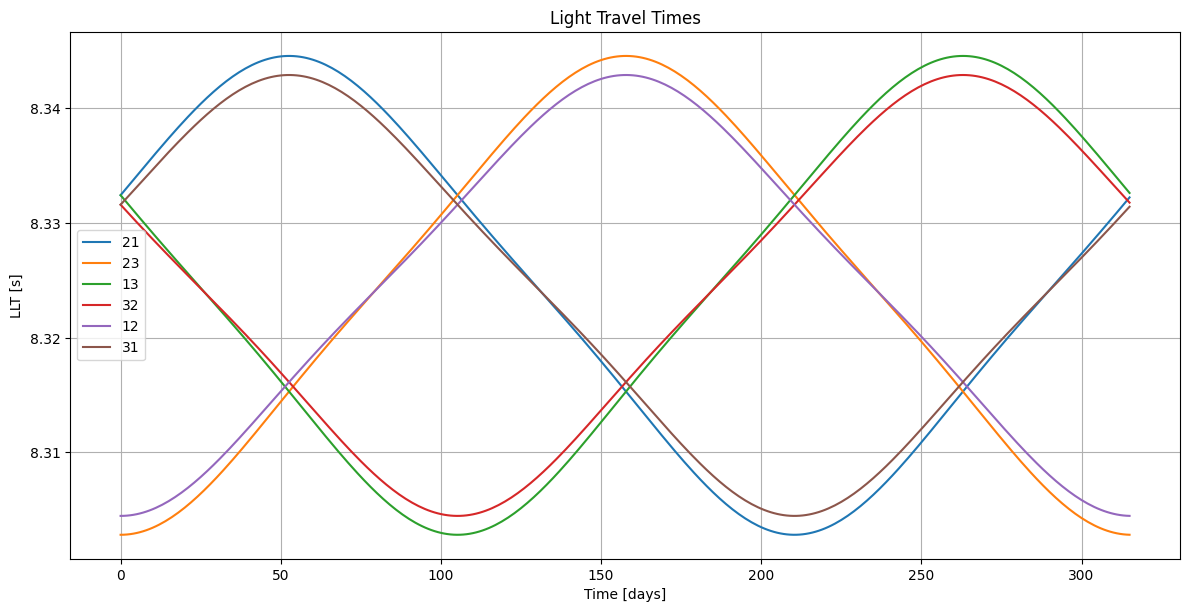

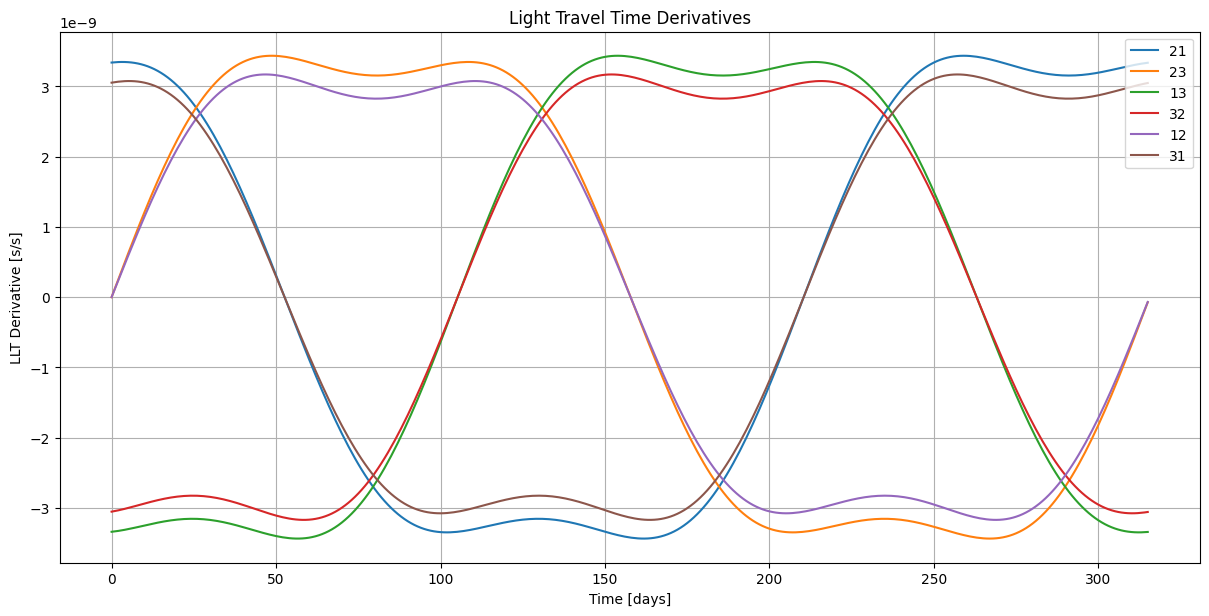

In [10]:
MOSAS = {"12", "23", "31", "13", "21", "32"}
with h5py.File(ORBIT_FILE, "r") as f:

    plt.figure(figsize=(12, 6))
    for i, mosa in enumerate(MOSAS):
        plt.plot(f["tcb/ltt"][:, i], label=mosa)
    plt.legend()
    plt.xlabel("Time [days]")
    plt.ylabel("LLT [s]")
    plt.grid(True, which='both', ls='-')
    plt.legend()
    plt.tight_layout()
    plt.title("Light Travel Times")

    plt.figure(figsize=(12, 6))
    for i, mosa in enumerate(MOSAS):
        plt.plot(f["tcb/d_ltt"][:, i], label=mosa)
    plt.grid(True, which='both', ls='-')
    plt.legend()
    plt.tight_layout()
    plt.xlabel("Time [days]")
    plt.ylabel("LLT Derivative [s/s]")
    plt.title("Light Travel Time Derivatives")

# Plot the GW strains

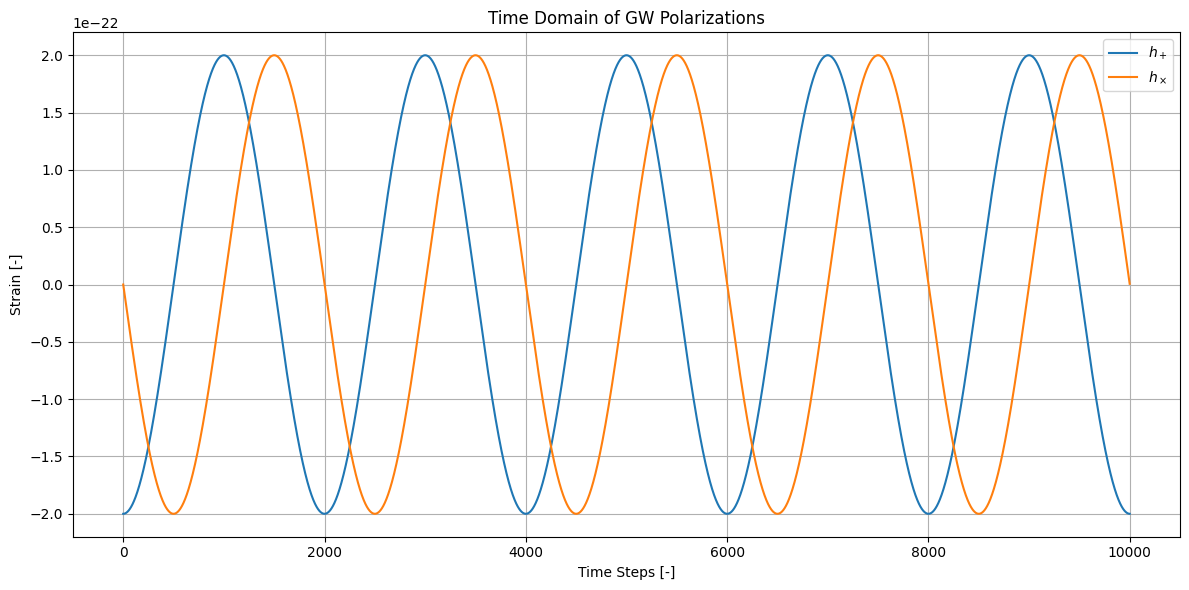

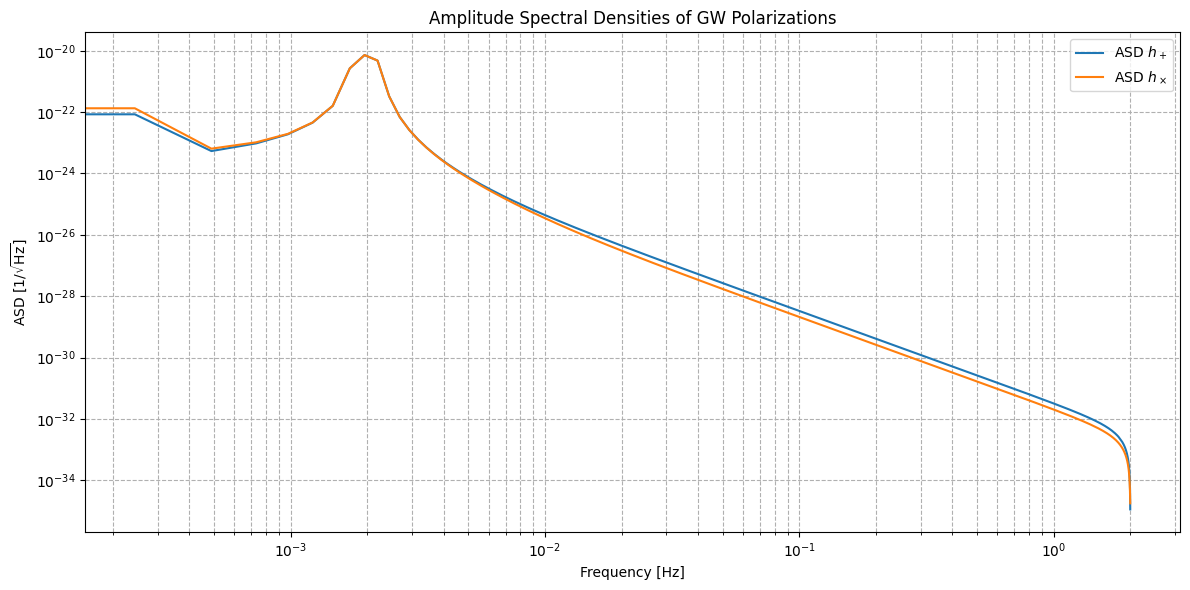

In [11]:
# --- Time Domain Plot ---
plt.figure(figsize=(12, 6))
plt.plot(gw_source.compute_hplus(t=time[0:10000]), label=r'$h_+$')
plt.plot(gw_source.compute_hcross(t=time[0:10000]), label=r'$h_\times$')
plt.xlabel('Time Steps [-]')
plt.ylabel('Strain [-]')
plt.title('Time Domain of GW Polarizations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- ASD Plot ---
fs = 1/tdi_params['dt']  # Sampling frequency

# Compute time series
h_plus = gw_source.compute_hplus(t=time)
h_cross = gw_source.compute_hcross(t=time)

# Compute ASD using Welch's method
f, Pxx_plus = welch(h_plus, fs=fs, window='hann', nperseg=2**14, scaling='density')
_, Pxx_cross = welch(h_cross, fs=fs, window='hann', nperseg=2**14, scaling='density')

# Plot ASDs
plt.figure(figsize=(12, 6))
plt.loglog(f, np.sqrt(Pxx_plus), label=r'ASD $h_+$')
plt.loglog(f, np.sqrt(Pxx_cross), label=r'ASD $h_\times$')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'ASD [1/$\sqrt{\mathrm{Hz}}$]')
plt.title('Amplitude Spectral Densities of GW Polarizations')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

# Get LISA instrument response

In [12]:
# --- Initialize LISA Instrument ---
instrument = Instrument(
    dt=tdi_params['dt'],
    size=tdi_params['N'],
    gws=GW_FILE,
    orbits=ORBIT_FILE,
    aafilter=None,
    physics_upsampling=1,
    lock='six',
    interpolation=["lagrange", tdi_params['n']]
)
instrument.disable_all_noises()
instrument.laser_asds = ForEachMOSA(30.0) # Hz / sqrt(Hz)
#instrument.ranging_biases = ForEachMOSA(30e-9) # Ranging biases of 30 ns - Enable this to observe how residual laser noise increases in the TDI outputs and partially obscures the injected signal.
instrument.simulate()

# --- Extract Data ---
data = Data.from_instrument(instrument)

Using default set of locking beatnote frequencies; this might cause interferometric beatnote frequencies to fall outside the requirement range of 5..25 MHz
You are using LISA Instrument in a version that might not be fully supported


# Plot LISA response 
<span style="font-size: 1.2em;">
The figure below shows the raw, noisy measurement from the interspacecraft interferometer of optical bench 12. Although the gravitational wave signal is present, it is obscured by dominant laser noise. To reveal the signal, TDI must first be applied.
</span>

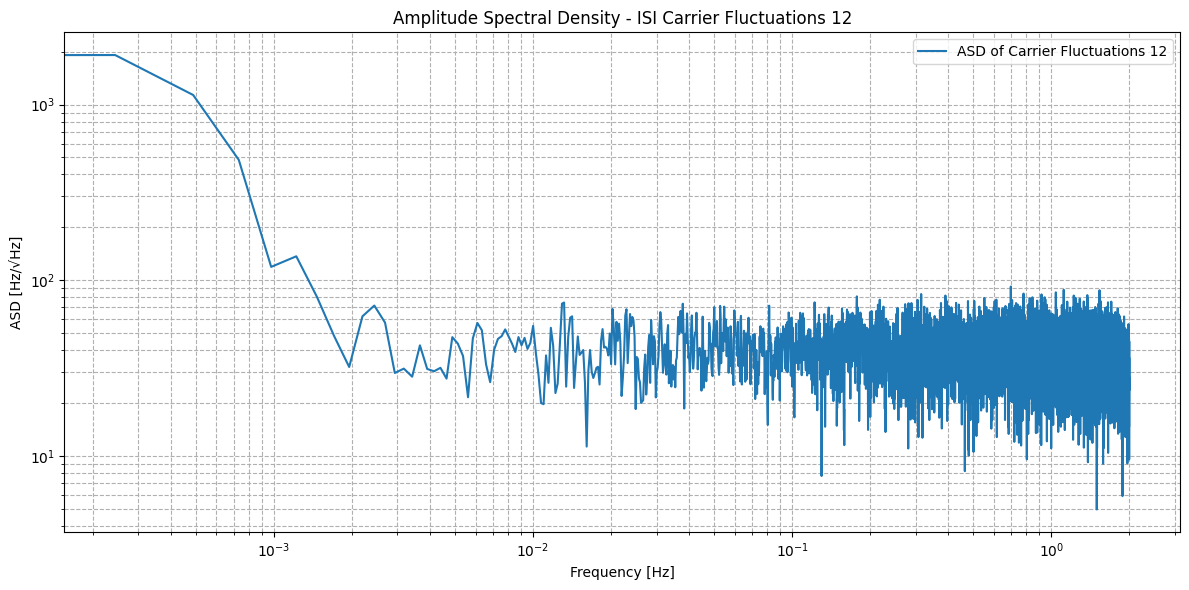

In [13]:
# --- Extract Time Series ---
carrier_fluct = instrument.isi_carrier_fluctuations['12'][500:-1]

# --- ASD Plot ---
fs = data.fs  # Assuming same sampling frequency as `data` earlier
f, Pxx_ISI = welch(carrier_fluct, fs=fs, window='hann', nperseg=2**14, scaling='density')

plt.figure(figsize=(12, 6))
plt.loglog(f, np.sqrt(Pxx_ISI), label='ASD of Carrier Fluctuations 12')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [Hz/√Hz]')
plt.title('Amplitude Spectral Density - ISI Carrier Fluctuations 12')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

# Compute TDI and plot result
<span style="font-size: 1.2em;">
The figure below shows the TDI channel after laser noise suppression. The injected gravitational wave signal, previously hidden beneath dominant laser noise, is now visible.  
So far, we have assumed perfect knowledge of the inter-spacecraft light travel times. To explore the impact of timing uncertainty, you can introduce a ranging bias of, e.g., 30 ns using  
<code>instrument.ranging_biases = ForEachMOSA(30e-9)</code>  
and observe how the noise level in the TDI output is affected.
</span>

You are using LISA Instrument in a version that might not be fully supported


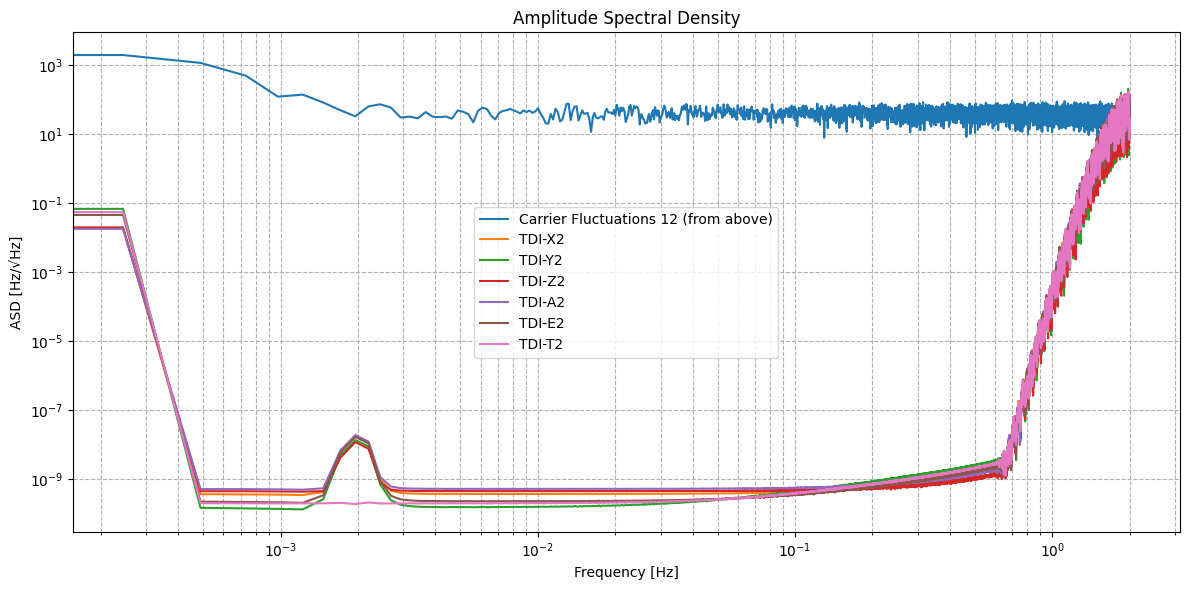

In [18]:
# --- Extract Data and use pyTDI ---
data = Data.from_instrument(instrument)

# TDI Michelson channels
X2 = michelson.X2.build(data.delays, data.fs)(data.measurements)
Y2 = michelson.Y2.build(data.delays, data.fs)(data.measurements)
Z2 = michelson.Z2.build(data.delays, data.fs)(data.measurements)

# Quasi-orthogonal TDI channesl
A2 = ortho.A2.build(data.delays, data.fs)(data.measurements)
E2 = ortho.E2.build(data.delays, data.fs)(data.measurements)
T2 = ortho.T2.build(data.delays, data.fs)(data.measurements)

# Remove invalid samples in the beginning (TDI initialization phase)
X2 = X2[1000:-1]
Y2 = Y2[1000:-1]
Z2 = Z2[1000:-1]

A2 = A2[1000:-1]
E2 = E2[1000:-1]
T2 = T2[1000:-1]

'''
# --- Time Series Plot ---
plt.figure(figsize=(12, 6))
plt.plot(X2, label='TDI-X (2.0)')
plt.xlabel('Time Steps [-]')
plt.ylabel('Magnitude [Hz]')
plt.legend()
plt.title('Time Domain - TDI-X2')
plt.grid(True)
plt.tight_layout()
plt.show()
'''

# --- ASD Plot ---
# Compute ASD using Welch's method
fs = data.fs  # Sampling frequency
f, Pxx = welch(X2, fs=fs, window='hann', nperseg=2**14, scaling='density')
f, Pyy = welch(Y2, fs=fs, window='hann', nperseg=2**14, scaling='density')
f, Pzz = welch(Z2, fs=fs, window='hann', nperseg=2**14, scaling='density')

f, Paa = welch(A2, fs=fs, window='hann', nperseg=2**14, scaling='density')
f, Pee = welch(E2, fs=fs, window='hann', nperseg=2**14, scaling='density')
f, Ptt = welch(T2, fs=fs, window='hann', nperseg=2**14, scaling='density')

plt.figure(figsize=(12, 6))

plt.loglog(f, np.sqrt(Pxx_ISI), label='Carrier Fluctuations 12 (from above)')

plt.loglog(f, np.sqrt(Pxx), label='TDI-X2')
plt.loglog(f, np.sqrt(Pyy), label='TDI-Y2')
plt.loglog(f, np.sqrt(Pzz), label='TDI-Z2')

plt.loglog(f, np.sqrt(Paa), label='TDI-A2')
plt.loglog(f, np.sqrt(Pee), label='TDI-E2')
plt.loglog(f, np.sqrt(Ptt), label='TDI-T2') # You can clearly see in the plot below how the injected gravitational wave signal is being suppressed in the T channel.

plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [Hz/√Hz]')
plt.title('Amplitude Spectral Density')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()